In [2]:
from gensim import corpora, models, similarities
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
import os
import pickle
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import time
from matplotlib import colors
pyLDAvis.enable_notebook()

#### 1. Initialize LDA -- compute prerequisite data for LDA 
- params:
    - folder_path: cleand preprocessed data folder
    - non_german_file_path: a list of all English files
- variables:
    - texts: list of input text
    - dct: [Dictionay](https://radimrehurek.com/gensim/corpora/dictionary.html) type, defined by gensim library
    - corpus: doc2bow, tokenized and nomalized list

In [3]:
def LDA_initialize(folder_path, non_german_file_path):
    
    #get a list of non_german files
    non_german_files = []
    with open(non_german_file_path, 'r') as fr:
        for line in fr:
            non_german_files.append(line.strip())
    
    texts = []
    filenames = []

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            if f[:-11] not in non_german_files:
                try:
                    with open(root+'/'+f, 'rb') as fr:
                        filenames.append(f)
                        document_tokens = pickle.load(fr)
                        texts.append(document_tokens)
                except:
                    print('Error while processing: ', f)
    
    dct = Dictionary(texts)
    corpus = [dct.doc2bow(doc) for doc in texts]
    
    return texts, dct, corpus

In [9]:
%%time
warnings.filterwarnings("ignore")
#please modify the path
non_german_file_path = '/home/bit/chao/LabShare/data/non_german_files.txt'
bank_quarterly_report_path = '/home/bit/chao/LabShare/data/chui_ma/bank_quarterly_report/'
texts, dct, corpus = LDA_initialize(bank_quarterly_report_path, non_german_file_path)

CPU times: user 820 ms, sys: 28 ms, total: 848 ms
Wall time: 870 ms


#### 2. LDA Topic Modeling and Model Evaluation
> step 1: get_model_list():
> > get a list of LDA models with different numbers of topics

> step 2: compute_CV_coherence_values(), compute_UM_coherence_values()
> > evaluate models using CV and UMass coherence scores

#### step 1: get_model_list(dictionary, corpus, limit, start=2, step=3)
- params:
    - dictionary: gensim dictionary
    - corpus: gensim corpus
    - start, limit, step: test topic numbers from **start** to **limit** with a step size **step**
- variables:
    - model_list: a list of LDA models

In [5]:
# https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

def get_model_list(dictionary, corpus, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)

    return model_list

#### step 2: compute_CV_coherence_values(model_list, dictionary, corpus, texts)

- params:
    - model_list : List of LDA topic models
    - dictionary : gensim dictionary
    - corpus : gensim corpus
    - texts : list of input texts

- variables:
    - coherence_values : Coherence values corresponding to the LDA model with respective number of topics

In [6]:
# https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

def compute_CV_coherence_values(model_list, dictionary, corpus, texts):
    coherence_values = []
    for model in model_list:
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values


#### step 2: compute_UMass_coherence_values(model_list, dictionary, corpus)

- params:
    - model_list : List of LDA topic models
    - dictionary : gensim dictionary
    - corpus : gensim corpus

- variables:
    - coherence_values : Coherence values corresponding to the LDA model with respective number of topics

In [7]:
# https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

def compute_UMass_coherence_values(model_list, dictionary, corpus):
    coherence_values = []
    for model in model_list:
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values    

#### main function of experiment

In [10]:
%%time
start = 5
limit = 20
step = 1

model_list = get_model_list(dictionary=dct, corpus=corpus, start=start, limit=limit, step=step)

UMass_coherence_values = compute_UMass_coherence_values(model_list, dictionary=dct, corpus=corpus)
CV_coherence_values = compute_CV_coherence_values(model_list, dictionary=dct, corpus=corpus, texts=texts)

CPU times: user 2min 20s, sys: 8.27 s, total: 2min 28s
Wall time: 1min 40s


#### visualize the evalution process
- params:
    - start, limit, step: test topic numbers from **start** to **limit** with a step size **step**
    - UMass_coherence_values: output from **compute_UMass_coherence_values** function
    - CV_coherence_values: output from **compute_CV_coherence_values** function

In [22]:
def visualize_coherence_scores(start, limit, step, UMass_coherence_values, CV_coherence_values):
    # Show UMass scores
    plt.figure()
    x = range(start, limit, step)
    plt.plot(x, UMass_coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("UMass Coherence score")
    plt.legend(("UMass_coherence_values"), loc='best')
    plt.show()

    # Show CV scores
    plt.figure()
    plt.plot(x, CV_coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("CV Coherence score")
    plt.legend(("CV_coherence_values"), loc='best')
    plt.show()

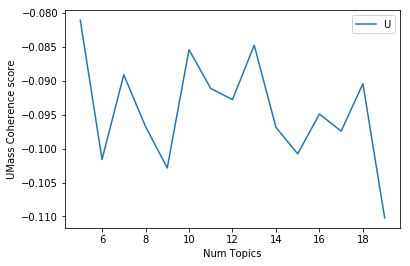

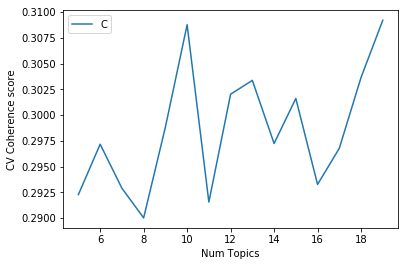

In [23]:
visualize_coherence_scores(start, limit, step, UMass_coherence_values, CV_coherence_values)

#### select the number of topics and visualize the LDA model
- selection scheme: test those numbers of topics with rather higher coherence scores

In [21]:
best_UMass_model = model_list[np.argmax(UMass_coherence_values) ]
pyLDAvis.gensim.prepare(best_UMass_model, corpus, dct)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.014363 -0.000730       1        1  53.000832
2      0.000654  0.003500       2        1  18.585978
4     -0.002728 -0.004878       3        1  17.720951
1     -0.010439  0.000141       4        1   5.488126
3     -0.001850  0.001967       5        1   5.204119, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
1443  Default  16949.000000             Mio  16949.000000  30.0000  30.0000
1481  Default   9180.000000             Mrd   9180.000000  29.0000  29.0000
264   Default   3925.000000            Bank   3925.000000  28.0000  28.0000
984   Default   4510.000000            Höhe   4510.000000  27.0000  27.0000
676   Default   2481.000000         Erträge   2481.000000  26.0000  26.0000
687   Default  10955.000000            Euro  10955.000000  25.0000  25.0000
1188  Default   3803.000000         Konzern   3803.000000  24.0000  24.0000
638   Default   4300.000000        Ergebnis   4300.000000  23.0000  23.0000
1690  Default   3688.000000         Quartal   3688.000000  22.0000  22.0000
2037  Default   2271.000000         Steuern   2271.000000  21.0000  21.0000
506   Default   3449.000000        Dezember   3449.000000  20.0000  20.0000
988   Default   3187.000000            IFRS   3187.000000  19.0000  19.0000
1815  Default   2152.000000         Risiken   2152.000000  18.0000  18.0000
1085  Default   2583.000000            Juni   2583.000000  17.0000  17.0000
1698  Default   2196.000000          Rahmen   2196.000000  16.0000  16.0000
1205  Default   2315.000000        Konzerns   2315.000000  15.0000  15.0000
1276  Default   2138.000000          Kunden   2138.000000  14.0000  14.0000
2151  Default   2091.000000     Unternehmen   2091.000000  13.0000  13.0000
2207  Default   1834.000000       Vergleich   1834.000000  12.0000  12.0000
161   Default   2209.000000         Anstieg   2209.000000  11.0000  11.0000
1873  Default   1874.000000        Rückgang   1874.000000  10.0000  10.0000
2245  Default   1606.000000  Vermögenswerte   1606.000000   9.0000   9.0000
629   Default   1812.000000     Entwicklung   1812.000000   8.0000   8.0000
2401  Default   1557.000000    Wesentlichen   1557.000000   7.0000   7.0000
288   Default   1945.000000           Basis   1945.000000   6.0000   6.0000
1851  Default   1857.000000  Risikovorsorge   1857.000000   5.0000   5.0000
932   Default   3176.000000        Halbjahr   3176.000000   4.0000   4.0000
1067  Default   2027.000000            Jahr   2027.000000   3.0000   3.0000
2514  Default   1473.000000    Zusammenhang   1473.000000   2.0000   2.0000
712   Default   2304.000000            Fair   2304.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
2401   Topic5    101.598511    Wesentlichen   1557.923218   0.2256  -5.6503
480    Topic5     29.930483     Darstellung    392.971252   0.3809  -6.8725
855    Topic5     59.484711       Geschäfts    868.592529   0.2746  -6.1856
207    Topic5     95.496567    Aufwendungen   1512.480469   0.1933  -5.7123
2458   Topic5     26.656797       Zeitwerts    346.771088   0.3901  -6.9883
1443   Topic5    754.543518             Mio  16949.679688  -0.1562  -3.6453
1565   Topic5     46.153347       Parameter    663.621338   0.2900  -6.4394
2037   Topic5    128.555542         Steuern   2271.460449   0.0839  -5.4150
1205   Topic5    128.875397        Konzerns   2315.572510   0.0672  -5.4125
1188   Topic5    193.357391         Konzern   3803.965820  -0.0235  -5.0068
984    Topic5    219.160492            Höhe   4510.878906  -0.0687  -4.8816
1815   Topic5    120.071198         Risiken   2152.379883   0.0695  -5.4833
1851   Topic5    106.378677  Risikovorsorge   1857.313477   0.0958  -5.6044
2514   Topic5     87.717293    Zusammenhang   1473.171631   0.1347  -5.7972
2207   